### Prepare the Dataset

In [ ]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os

For the data, you can click download at
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Or you can download it by the following cell:

In [ ]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk
From (redirected): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk&confirm=t&uuid=16ee20bc-ad61-4fba-94c9-8b0e440b641e
To: /content/Reviews.csv
100% 301M/301M [00:05<00:00, 53.5MB/s]


In [ ]:
# Remeber to change the path here for the corresponding files you need
food_reviews = pd.read_csv('Reviews.csv')
print(food_reviews.shape)
df = food_reviews.head(1000)
print(df.shape)

(568454, 10)
(1000, 10)


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

We check and preprocess the data for modeling in this part. We build these features:

- Numeric features
- Categorical features (one-hot encoded)
- Embedding features

#### import packages

In [ ]:
!pip install sentence_transformers --quiet
from sentence_transformers import SentenceTransformer
import pandas as pd
from datetime import datetime
from collections import Counter
import math
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.4 MB/s eta 0:00:00


#### Deal with NULLs

for each column in the Dataset, we inspect its data type, check nulls and the number of unique values. We can tell from below that there are some missing values in 'ProfileName' and 'Summary' columns.

Column 'ProfileName' contains reviewers' name, it does not matter that much, if we cannot trace them. Thus, we keep these instances.

As for 'Summary' column, among those rows which contain null values, we witnessed abnormalities, since it turns out that there is one customer who comments on different product with same reviews at the same time. We decided to drop these rows.

In [ ]:
def desp(df):
  descrip = [['Col name', 'Data Type', '#Missing Value', '#Unique']]
  for col in df.columns:
    descrip.append([col, str(df[col].dtypes), sum(df[col].isnull()), len(df[col].unique())])
  return descrip
for i in desp(food_reviews):
  print("%22s,%18s,%18s,%18s" % tuple(i))

              Col name,         Data Type,    #Missing Value,           #Unique
                    Id,             int64,                 0,            568454
             ProductId,            object,                 0,             74258
                UserId,            object,                 0,            256059
           ProfileName,            object,                16,            218417
  HelpfulnessNumerator,             int64,                 0,               231
HelpfulnessDenominator,             int64,                 0,               234
                 Score,             int64,                 0,                 5
                  Time,             int64,                 0,              3168
               Summary,            object,                27,            295743
                  Text,            object,                 0,            393579


In [ ]:
food_reviews=food_reviews[food_reviews['Summary'].isnull()==False]

In [ ]:
food_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


#### Drop Useless Columns



We consider a column to be useless if over 10% values from the column are different. Admittedly, some person tend to leave negative reviews, which can help us do sentiment test, however, there are 256056 different users in current dataset, the possibility that we can utilize user information data is low.

Since `Summary` and `Text` contains text data, it's natural for them to contain over 50% unique values, we don't drop these two columns.

In [ ]:
feature_name=food_reviews.columns
for i in feature_name:
  if len(set(food_reviews[i].to_list()))>0.1*len(set(food_reviews['Id'].to_list())):
    print(i,100*len(set(food_reviews[i].to_list()))/len(set(food_reviews['Id'].to_list())),"% of the data in the column have different values.")

Id 100.0 % of the data in the column have different values.
ProductId 13.06377072165819 % of the data in the column have different values.
UserId 45.04641756989024 % of the data in the column have different values.
ProfileName 38.424283153333676 % of the data in the column have different values.
Summary 52.028140816674785 % of the data in the column have different values.
Text 69.23949777192146 % of the data in the column have different values.


Since we do not utilize `ProductId` and `UserId` information, it is meaningless to use `HelpfullnessNumerator` and `HelpfulnessDenominator` column. Thus, we drop it as well.

In [ ]:
food_reviews=food_reviews.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator'])

#### Deal with numeric features

Among the rest columns, we think `Time` can be used as a good feature, since it is possible that people tend to leave more negative reviews simply because they feel emotional in winter. 

We can prove the assumption through data visualization.

Through the graphs below, we can tell that our assumption is not right. Though it is the case that more people tend to give negative scores in winter, they also tend to give more possitive scores.

However, the graph demonstrates that, people tend to give more extreme scores in winter, while more neural scores in spring and summer, which means season affect people's behavior to some extend, therefore we include season as a feature.

In [ ]:
def timestamp_to_datetime(timestamp):
  dt_object = datetime.fromtimestamp(timestamp)
  if dt_object.month>=3 and dt_object.month<=5:
    return 'Spring'
  elif dt_object.month>=6 and dt_object.month<=8:
    return 'Summer'
  elif dt_object.month>=9 and dt_object.month<=11:
    return 'Autumn'
  else:
    return 'Winter'
food_reviews['Season']=food_reviews['Time'].apply(lambda x:timestamp_to_datetime(x))

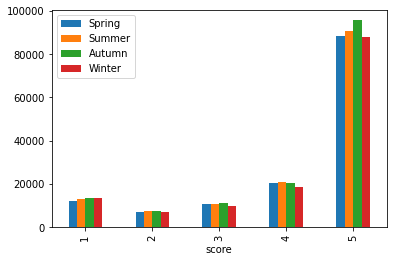

In [ ]:
#@title Score distribution
#@markdown We can take a brief look at the number of reviews among each season.
data=sorted(Counter(food_reviews['Score'].tolist()).items(),key=lambda i:i[0])
Spring_data=sorted(Counter(food_reviews[food_reviews['Season']=='Spring']['Score'].tolist()).items(),key=lambda i:i[0])
Summer_data=sorted(Counter(food_reviews[food_reviews['Season']=='Summer']['Score'].tolist()).items(),key=lambda i:i[0])
Autumn_data=sorted(Counter(food_reviews[food_reviews['Season']=='Autumn']['Score'].tolist()).items(),key=lambda i:i[0])
Winter_data=sorted(Counter(food_reviews[food_reviews['Season']=='Winter']['Score'].tolist()).items(),key=lambda i:i[0])
score_data={}
score_data['score']=list(range(1,6))
# score_data['Whole']=[i[1] for i in data]
score_data['Spring']=[i[1] for i in Spring_data]
score_data['Summer']=[i[1] for i in Summer_data]
score_data['Autumn']=[i[1] for i in Autumn_data]
score_data['Winter']=[i[1] for i in Winter_data]
score_df=pd.DataFrame(score_data)
# print(score_df)
score_df.plot(x='score',y=[1,2,3,4],kind='bar')
plt.show()

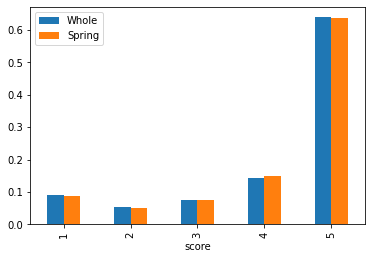

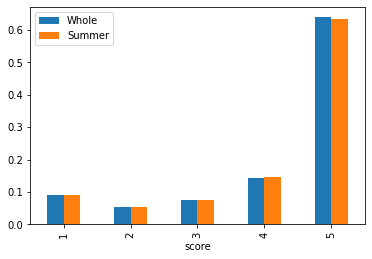

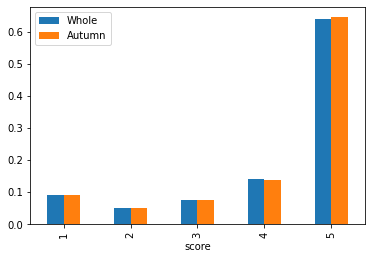

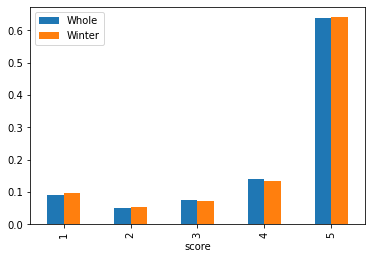

In [ ]:
#@title Percentage of scores
#@markdown We then compute what percentage of people tend to give a certain score, and compare the result vs the whole dataset for each season.
#@markdown We can tell from the graph that the masses tend to give more extreme scores during winter months, and less extreme scores during spring and summer.
def precentage_plot(Season_data,Season_name):
  data_percentage=[i[1] for i in data]/np.sum(data,axis=0)[1]
  season_p=[i[1] for i in Season_data]/np.sum(Season_data,axis=0)[1]
  score_p={}
  score_p['score']=list(range(1,6))
  score_p['Whole']=data_percentage
  score_p[Season_name]=season_p
  score_p_df=pd.DataFrame(score_p)
  # print(score_df)
  score_p_df.plot(x='score',y=[1,2],kind='bar')
  plt.show()
precentage_plot(Spring_data,'Spring')
precentage_plot(Summer_data,'Summer')
precentage_plot(Autumn_data,'Autumn')
precentage_plot(Winter_data,'Winter')

In [ ]:
food_reviews=food_reviews.drop(columns=['Time'])

#### Encode categorical features

As we include `Season` as our new feature. We are supposed to do one-hot encoding.

Note: we do not do one-hot encoding on column `Score` since more punishment should be made if we wrongly assign Score-5 to Score-1 compared to wrongly assign Score-5 to Score-4

In [ ]:
dummies=pd.get_dummies(food_reviews.Season)
food_reviews_1h=pd.concat([food_reviews,dummies],axis=1)
food_reviews_1h=food_reviews_1h.drop(columns=['Season'])

#### Creat Text Embedding as Features


In [ ]:
#@markdown We combine `Summary` and `Text` into one column and naming it `Full_Text`, since we want to extract information from both text.
#@markdown After this step, we store food_reviews to a csv since we are donw with numerical and categorical features, in the following part, we concentrate on dealing with text data
food_reviews_1h['Full_Text']=food_reviews_1h['Summary']+". "+food_reviews_1h['Text']
food_reviews=food_reviews_1h.drop(columns=['Summary','Text'])
food_reviews.to_csv('/content/drive/MyDrive/CIS519/food_reviews.csv')

In [ ]:
food_reviews=pd.read_csv('/content/drive/MyDrive/CIS519/food_reviews.csv',index_col=False).drop(columns=['Unnamed: 0'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


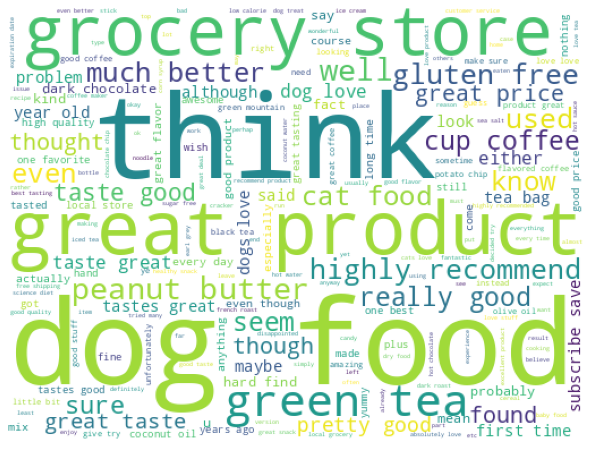

In [ ]:
#@title Word Cloud for Full_Text(`Summary`+`Text`)
#@markdown We add 'br' to stopwords, since it has no semantic meaning.
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords.add("br")

def tokenize_content(content):
  content = nltk.word_tokenize(content)
  contents = [x.lower() for x in content if x.lower() not in stopwords and x.lower().isalpha()]
  # print(contents)
  return contents

def get_col_tokens(df,col_name):
  col_data=df[col_name].to_list()
  top_tokens_list=[]
  for i in col_data:
    top_tokens_list+=tokenize_content(i)
  
  return top_tokens_list

plt.subplots(figsize = (20, 8))
top_token=get_col_tokens(food_reviews,'Full_Text')
wordcloud = WordCloud(background_color = 'white',width = 512, height = 384).generate(" ".join(top_token))
# print(top_token)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Column `Text` contains rich semantic meanings, we encode them with BERT.

In [ ]:
from sentence_transformers import SentenceTransformer
embd_model = SentenceTransformer('all-MiniLM-L6-v2')
food_reviews['Full_Text']=food_reviews['Full_Text'].apply(lambda x:str(x))
embeddings = embd_model.encode(food_reviews['Full_Text'].tolist())
food_reviews['FullText_emb']=list(embeddings)
food_reviews.to_pickle('/content/drive/MyDrive/CIS519/food_reviews_emb.df')

Combine 'Summmary', 'Season', 'Text' together to generate embeddings

In [ ]:
food_reviews=food_reviews.drop(columns=['Time'])

In [ ]:
food_reviews['Full_Text_Season']=food_reviews['Season']+". "+food_reviews['Summary']+". "+food_reviews['Text']
food_reviews=food_reviews.drop(columns=['Season','Summary','Text'])

In [ ]:
food_reviews

,Score,Full_Text_Season
0,5,Spring. Good Quality Dog Food. I have bought s...
1,1,Autumn. Not as Advertised. Product arrived lab...
2,4,"Summer. ""Delight"" says it all. This is a confe..."
3,2,Summer. Cough Medicine. If you are looking for...
4,5,Autumn. Great taffy. Great taffy at a great pr...
...,...,...
568449,5,Spring. Will not do without. Great for sesame ...
568450,2,Spring. disappointed. I'm disappointed with th...
568451,5,Winter. Perfect for our maltipoo. These stars ...
568452,5,Spring. Favorite Training and reward treat. Th...


In [ ]:
from sentence_transformers import SentenceTransformer
embd_model = SentenceTransformer('all-MiniLM-L6-v2')
food_reviews['Full_Text_Season']=food_reviews['Full_Text_Season'].apply(lambda x:str(x))
embeddings = embd_model.encode(food_reviews['Full_Text_Season'].tolist())
food_reviews['FullTextSeason_emb']=list(embeddings)
food_reviews.to_pickle('/content/drive/MyDrive/CIS519/food_reviews_emb_with_season.df')

In [ ]:
food_reviews

,Score,Full_Text_Season,FullTextSeason_emb
0,5,Spring. Good Quality Dog Food. I have bought s...,"[-0.02059301, -0.038072094, 0.041654024, 0.038..."
1,1,Autumn. Not as Advertised. Product arrived lab...,"[0.03214882, 0.027212264, 0.050843004, 0.04709..."
2,4,"Summer. ""Delight"" says it all. This is a confe...","[-0.058231466, -0.0064712833, -0.03354285, 0.1..."
3,2,Summer. Cough Medicine. If you are looking for...,"[-0.015470242, -0.025296245, -0.030573344, 0.0..."
4,5,Autumn. Great taffy. Great taffy at a great pr...,"[0.0017022332, -0.023680616, 0.07303144, 0.050..."
...,...,...,...
568449,5,Spring. Will not do without. Great for sesame ...,"[-0.02723639, 0.013740339, -0.02667846, 0.0528..."
568450,2,Spring. disappointed. I'm disappointed with th...,"[-0.02522691, -0.04481382, 0.021672586, 0.0468..."
568451,5,Winter. Perfect for our maltipoo. These stars ...,"[-0.012271979, -0.015069318, 0.059737574, 0.14..."
568452,5,Spring. Favorite Training and reward treat. Th...,"[0.013866469, -0.08007706, 0.030529993, 0.0324..."


In [ ]:
food_reviews=pd.read_pickle('/content/drive/MyDrive/CIS519/food_reviews_emb_with_season.df')

## Train-test split

After dealing with numerical, categorical and text features. We then take a look at our target column.

In [ ]:
food_reviews_emb=pd.read_pickle('/content/drive/MyDrive/CIS519/food_reviews_emb_with_season.df')

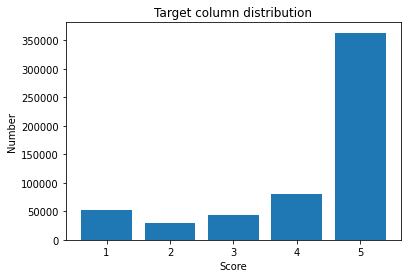

In [ ]:
#@title Target data's distribution
#@markdown The graph illustrates that our data is imbalanced, since there are more 5-score reviews than the other. 

#@markdown However, since 1. we have enough of the minority outcome to make useful predictions,
#@markdown 2. The model cannot achieve a better than 60% accuracy if we only predict score-5,
#@markdown
#@markdown We do not need to do resampling here.
score=Counter(food_reviews['Score'])
plt.bar(score.keys(),score.values())
plt.xlabel('Score')
plt.ylabel('Number')
plt.title('Target column distribution')
plt.show()

In [ ]:
train_df,test_df=train_test_split(food_reviews, test_size=0.2, random_state=42, shuffle=True)

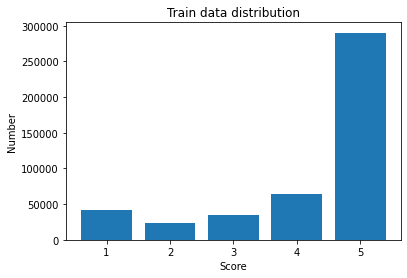

In [ ]:
#@markdown visualize train data distribution
score=Counter(train_df['Score'])
plt.bar(score.keys(),score.values())
plt.xlabel('Score')
plt.ylabel('Number')
plt.title('Train data distribution')
plt.show()

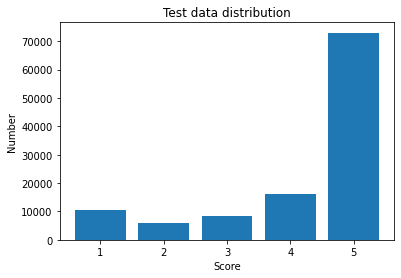

In [ ]:
#@markdown visualize test data distribution
score=Counter(test_df['Score'])
plt.bar(score.keys(),score.values())
plt.xlabel('Score')
plt.ylabel('Number')
plt.title('Test data distribution')
plt.show()

In [ ]:
#@title Save train and test data to csvs
#@markdown From the graphs above, we can tell that Training dataset and Testing dataset follows a similar distribution as Whole dataset
train_df.to_pickle('/content/drive/MyDrive/CIS519/training_emb.df')
test_df.to_pickle('/content/drive/MyDrive/CIS519/testing_emb.df')

#### Deal with imbalance data


In [ ]:
import numpy as np
from sklearn.utils import resample

# Identify majority class label
majority_label = 5
majority_indices = train_df.index[train_df['Score'] == majority_label].tolist()
num_instances_to_remove = int(1/2*len(majority_indices))
majority_indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
# df_downsampled = df.drop(majority_indices_to_remove)
majority_indices_to_remove
train_df=train_df.drop(majority_indices_to_remove)

In [ ]:
train_df.to_pickle('/content/drive/MyDrive/CIS519/training_emb.df')

## Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Import for Model
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
#@title Save train and test data to csvs after dealt with imbalance
#@markdown From the graphs above, we can tell that Training dataset and Testing dataset follows a similar distribution as Whole dataset
train_df.to_pickle('/content/drive/MyDrive/CIS519/X_training.df')
test_df.to_pickle('/content/drive/MyDrive/CIS519/X_testing.df')

In [ ]:
train_df=pd.read_pickle('/content/drive/MyDrive/CIS519/training_emb.df')
test_df=pd.read_pickle('/content/drive/MyDrive/CIS519/testing_emb.df')

In [ ]:
test_df=test_df.drop('Full_Text_Season',axis=1)
train_df=train_df.drop('Full_Text_Season',axis=1)

In [ ]:
test_df

,Score,FullTextSeason_emb
41434,4,"[0.008593277, -0.03988359, -0.057682592, 0.023..."
209481,4,"[-0.079834715, -0.009931096, -0.0060161264, 0...."
247306,5,"[-0.029119495, -0.048342347, 0.04080771, 0.111..."
80089,4,"[0.011135853, -0.07372101, -0.012624669, 0.032..."
218580,2,"[-0.042883705, -0.07305037, 0.06997447, 0.0498..."
...,...,...
300455,5,"[-0.08823457, -0.05247034, 0.030666748, 0.0251..."
4528,5,"[-0.012190261, -0.06556749, 0.04329492, 0.0652..."
292892,3,"[-0.014498227, -0.08291247, 0.07009738, 0.0472..."
363367,5,"[0.028452188, 0.10209669, 0.039535597, 0.02951..."


### Baseline Models with Season Embedded

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
X_train=np.vstack(train_df['FullTextSeason_emb'].values)
y_train=train_df['Score']
X_test=np.vstack(test_df['FullTextSeason_emb'].values)
y_test=test_df['Score']

In [ ]:
#@title Logistic Regression With Season Embedded
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The f1 score of our logistic regression baseline model is {}".format(f1_score(y_test, y_pred,average='macro')))
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

The f1 score of our logistic regression baseline model is 0.4514891852618813
[[ 7293   530   727   379  1414]
 [ 2264   700  1231   589  1174]
 [ 1388   531  2248  2017  2250]
 [  779   201  1218  4792  8986]
 [ 1870   276  1118  5552 64159]]


In [ ]:
#@title MLP With Season Embedded
# import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.conv1 = torch.nn.Conv2d(1, 16, 3, 3)
        # self.batch_norm1 = torch.nn.BatchNorm1d(num_features=16)
        self.fc1 = nn.Linear(384, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3=nn.Linear(64,5)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return F.relu(x)


class CONFIG:
    batch_size = 64
    num_epochs = 10
    initial_learning_rate = 0.002
    initial_weight_decay = 0.001

    lrs_kwargs = {
        # You can pass arguments to the learning rate scheduler
        # constructor here.
        "step_size": 4,
        "gamma": 0.7,
    }

train_target = torch.from_numpy(train_df['Score'].values)-1
train_feature= torch.from_numpy(np.vstack(train_df['FullTextSeason_emb'].values))
train_tensor = data_utils.TensorDataset(train_feature, train_target) 

test_target = torch.from_numpy(test_df['Score'].values)-1
test_feature= torch.from_numpy(np.vstack(test_df['FullTextSeason_emb'].values))
test_tensor = data_utils.TensorDataset(test_feature, test_target)

# print(train_data.shape)
train_dataloader = DataLoader(train_tensor, batch_size=CONFIG.batch_size, shuffle=True)
test_dataloader = DataLoader(test_tensor, batch_size=CONFIG.batch_size, shuffle=True)




In [ ]:
from tqdm import tqdm

model=MLP()
optimizer=torch.optim.Adam(model.parameters(),lr=CONFIG.initial_learning_rate)
criterion = nn.CrossEntropyLoss()
model.to(DEVICE)

def compute_accuracy(model, data_loader):
    model.eval()
    # Initialize the number of correct predictions:
    num_correct = 0
    num_correct_binary=0
    # Loop over the data:
    predictions=[]
    y_true=[]
    for x, y in data_loader:
        # Move the data to the device:
        x, y = x.to(DEVICE), y.to(DEVICE)
        # Forward pass:
        y_hat = model(x.to(torch.float32))
        # Compute the predictions:
        prediction = torch.argmax(y_hat.cpu(), dim=1)
        # print(prediction.shape)
        predictions=np.concatenate((predictions,prediction), axis=0)
        y_true=np.concatenate((y_true,y.cpu()), axis=0)
        
    f1=sklearn.metrics.f1_score(y_true,predictions,average='macro')
    accuracy = sklearn.metrics.accuracy_score(y_true,predictions)
    return accuracy,f1


for epoch in range(CONFIG.num_epochs):
    model.train()
    for x, y in tqdm(train_dataloader):
      # Move the data to the device:
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Zero the gradients:
      optimizer.zero_grad()
      # Forward pass:
      y_hat = model(x.to(torch.float32))
      # Compute the loss:
      loss = criterion(y_hat, y)
      # Backward pass:
      loss.backward()
      # Update the parameters:
      optimizer.step()
    # Set the model to evaluation mode:
    model.eval()
    # Compute the accuracy on the test data:
    accuracy, f1 = compute_accuracy(model, test_dataloader)
    print(f"Epoch {epoch + 1} | Test Accuracy: {accuracy:.2f}, F1 Score:{f1:.2f} ")

100%|██████████| 4839/4839 [00:11<00:00, 408.07it/s]


Epoch 1 | Test Accuracy: 0.69, F1 Score:0.36 


100%|██████████| 4839/4839 [00:11<00:00, 415.05it/s]


Epoch 2 | Test Accuracy: 0.71, F1 Score:0.44 


100%|██████████| 4839/4839 [00:11<00:00, 435.28it/s]


Epoch 3 | Test Accuracy: 0.71, F1 Score:0.45 


100%|██████████| 4839/4839 [00:10<00:00, 447.60it/s]


Epoch 4 | Test Accuracy: 0.72, F1 Score:0.46 


100%|██████████| 4839/4839 [00:10<00:00, 457.12it/s]


Epoch 5 | Test Accuracy: 0.72, F1 Score:0.46 


100%|██████████| 4839/4839 [00:11<00:00, 432.92it/s]


Epoch 6 | Test Accuracy: 0.72, F1 Score:0.47 


100%|██████████| 4839/4839 [00:11<00:00, 423.14it/s]


Epoch 7 | Test Accuracy: 0.74, F1 Score:0.47 


100%|██████████| 4839/4839 [00:11<00:00, 407.24it/s]


Epoch 8 | Test Accuracy: 0.72, F1 Score:0.48 


100%|██████████| 4839/4839 [00:11<00:00, 408.92it/s]


Epoch 9 | Test Accuracy: 0.72, F1 Score:0.48 


100%|██████████| 4839/4839 [00:11<00:00, 410.21it/s]


Epoch 10 | Test Accuracy: 0.73, F1 Score:0.48 


### Baseline model

We use logistic regression as baseline model.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
X_train_emb=np.vstack(train_df['FullText_emb'].values)
X_train_season=train_df[['Spring','Summer','Autumn','Winter']].values
X_train=np.concatenate((X_train_season,X_train_emb),axis=1)
y_train=train_df['Score']
X_test_emb=np.vstack(test_df['FullText_emb'].values)
X_test_season=test_df[['Spring','Summer','Autumn','Winter']].values
X_test=np.concatenate((X_test_season,X_test_emb),axis=1)
y_test=test_df['Score']

#### Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The f1 score of our logistic regression baseline model is {}".format(f1_score(y_test, y_pred,average='macro')))

The f1 score of our logistic regression baseline model is 0.462576560660753


In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print("The f1 score of our logistic regression baseline model is {}".format(f1_score(y_test, y_pred,average=None)))

The f1 score of our logistic regression baseline model is [0.6145955  0.1940172  0.32328297 0.32765663 0.85333051]


In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[ 7369   548   741   357  1328]
 [ 2211   801  1257   613  1076]
 [ 1348   547  2450  1870  2219]
 [  815   181  1221  4733  9026]
 [ 1894   222  1054  5341 64464]]


### Add data shift

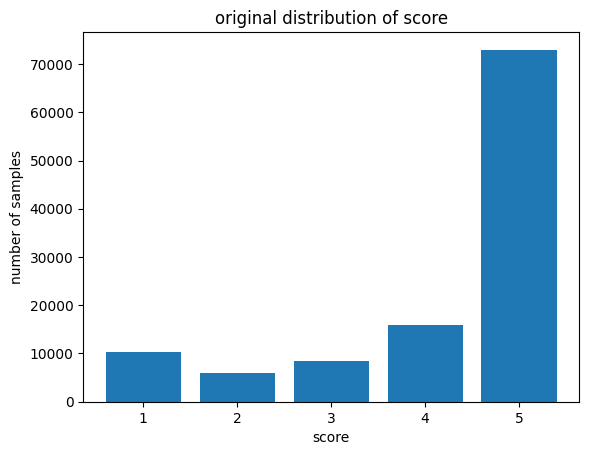

In [ ]:
#@title Original Distribution of Test Dataset
distribution=[test_df[test_df['Score']==1].shape[0],test_df[test_df['Score']==2].shape[0],test_df[test_df['Score']==3].shape[0],test_df[test_df['Score']==4].shape[0],test_df[test_df['Score']==5].shape[0]]
plt.bar(list(range(1,6)),distribution)
plt.title("original distribution of score")
plt.xlabel("score")
plt.ylabel("number of samples")
plt.show()

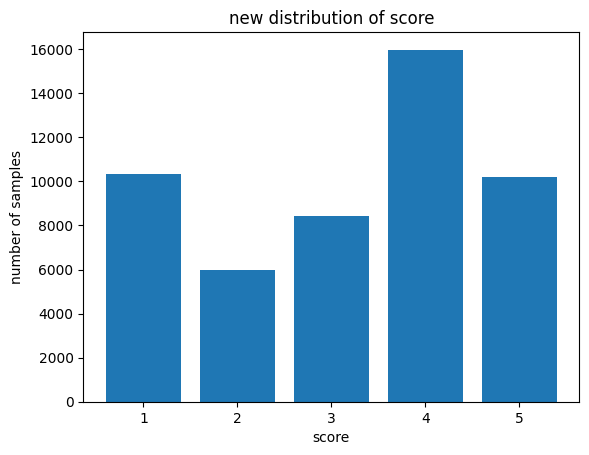

In [ ]:
#@title New Distribution With Data Shift
test_0to4_df=test_df[test_df['Score']!=5]
# test_0to4=np.vstack(test_0to4_df['FullText_emb'].values)
test_0to4_emb=np.vstack(test_0to4_df['FullText_emb'].values)
test_0to4_season=test_0to4_df[['Spring','Summer','Autumn','Winter']].values
test_0to4=np.concatenate((test_0to4_season,test_0to4_emb),axis=1)
line5=int(sum(distribution[:4])/4)
test_5_df=test_df[test_df['Score']==5].head(line5)
# test_5=np.vstack(test_5_df['FullText_emb'].values)
test_5_emb=np.vstack(test_5_df['FullText_emb'].values)
test_5_season=test_5_df[['Spring','Summer','Autumn','Winter']].values
test_5=np.concatenate((test_5_season,test_5_emb),axis=1)
test_new=np.concatenate((test_0to4,test_5), axis=0)
y_test_new0to4=test_0to4_df['Score']
y_test_new5=test_5_df["Score"]
y_test_new=np.concatenate((y_test_new0to4,y_test_new5), axis=0)
distribution_new=distribution[:4]+[line5]
plt.bar(list(range(1,6)),distribution_new)
plt.title("new distribution of score")
plt.xlabel("score")
plt.ylabel("number of samples")
plt.show()

In [ ]:
y_pred_new=clf.predict(test_new)
print("The f1 score of our logistic regression baseline model is {}".format(f1_score(y_pred_new, y_test_new,average='macro')))

The f1 score of our logistic regression baseline model is 0.4278767623650895


#### If not dealt with imbalance

In [ ]:
before_imbalance_train_df=pd.read_pickle('/content/drive/MyDrive/CIS519/fr_training_emb.df')
before_imbalance_test_df=pd.read_pickle('/content/drive/MyDrive/CIS519/fr_testing_emb.df')

In [ ]:
bi_X_train_emb=np.vstack(before_imbalance_train_df['FullText_emb'].values)
bi_X_train_season=before_imbalance_train_df[['Spring','Summer','Autumn','Winter']].values
bi_X_train=np.concatenate((bi_X_train_season,bi_X_train_emb),axis=1)
bi_y_train=before_imbalance_train_df['Score']
bi_X_test_emb=np.vstack(before_imbalance_test_df['FullText_emb'].values)
bi_X_test_season=before_imbalance_test_df[['Spring','Summer','Autumn','Winter']].values
bi_X_test=np.concatenate((bi_X_test_season,bi_X_test_emb),axis=1)
bi_y_test=before_imbalance_test_df['Score']

In [ ]:
clf = LogisticRegression(random_state=0).fit(bi_X_train, bi_y_train)
bi_y_pred=clf.predict(bi_X_test)
print("The f1 score of our logistic regression baseline model without dealing with imbalance is {}".format(f1_score(bi_y_test, bi_y_pred,average='macro')))

The f1 score of our logistic regression baseline model without dealing with imbalance is 0.42854318534752356


In [ ]:
cm = metrics.confusion_matrix(bi_y_test, bi_y_pred)
print(cm)

[[ 6872   466   620   130  2255]
 [ 2033   665  1067   270  1923]
 [ 1194   465  2109  1015  3651]
 [  632   122   954  2022 12246]
 [ 1238   130   648  1305 69654]]


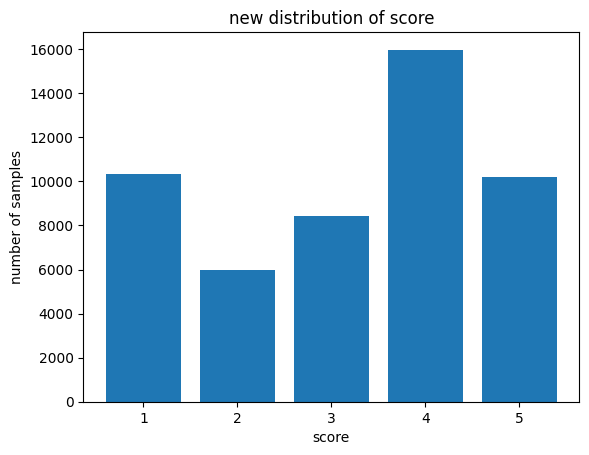

In [ ]:
#@title New Distribution With Data Shift
test_0to4_df=test_df[before_imbalance_test_df['Score']!=5]
# test_0to4=np.vstack(test_0to4_df['FullText_emb'].values)
test_0to4_emb=np.vstack(test_0to4_df['FullText_emb'].values)
test_0to4_season=test_0to4_df[['Spring','Summer','Autumn','Winter']].values
test_0to4=np.concatenate((test_0to4_season,test_0to4_emb),axis=1)
line5=int(sum(distribution[:4])/4)
test_5_df=test_df[before_imbalance_test_df['Score']==5].head(line5)
# test_5=np.vstack(test_5_df['FullText_emb'].values)
test_5_emb=np.vstack(test_5_df['FullText_emb'].values)
test_5_season=test_5_df[['Spring','Summer','Autumn','Winter']].values
test_5=np.concatenate((test_5_season,test_5_emb),axis=1)
test_new=np.concatenate((test_0to4,test_5), axis=0)
y_test_new0to4=test_0to4_df['Score']
y_test_new5=test_5_df["Score"]
y_test_new=np.concatenate((y_test_new0to4,y_test_new5), axis=0)
distribution_new=distribution[:4]+[line5]
plt.bar(list(range(1,6)),distribution_new)
plt.title("new distribution of score")
plt.xlabel("score")
plt.ylabel("number of samples")
plt.show()

In [ ]:
y_pred_new=clf.predict(test_new)
print("The f1 score of our logistic regression baseline model without dealing with imbalance is {}".format(f1_score(y_pred_new, y_test_new,average='macro')))

The f1 score of our logistic regression baseline model without dealing with imbalance is 0.366117258033158


### MLP



####import packages


In [ ]:
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
from math import sqrt
import torch.utils.data as data_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader
import numpy as np
import sklearn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#### define the model

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.conv1 = torch.nn.Conv2d(1, 16, 3, 3)
        # self.batch_norm1 = torch.nn.BatchNorm1d(num_features=16)
        self.fc1 = nn.Linear(388, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3=nn.Linear(64,5)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return F.relu(x)


class CONFIG:
    batch_size = 64
    num_epochs = 10
    initial_learning_rate = 0.005
    initial_weight_decay = 0.001

    lrs_kwargs = {
        # You can pass arguments to the learning rate scheduler
        # constructor here.
        "step_size": 4,
        "gamma": 0.7,
    }

#### dataloader

In [ ]:
train_target = torch.from_numpy(train_df['Score'].values)-1
train_feature= torch.from_numpy(np.concatenate((train_df[['Spring','Summer','Autumn','Winter']].values,np.vstack(train_df['FullText_emb'].values)),axis=1))
train_tensor = data_utils.TensorDataset(train_feature, train_target) 

test_target = torch.from_numpy(test_df['Score'].values)-1
test_feature= torch.from_numpy(np.concatenate((test_df[['Spring','Summer','Autumn','Winter']].values,np.vstack(test_df['FullText_emb'].values)),axis=1))
test_tensor = data_utils.TensorDataset(test_feature, test_target)

# print(train_data.shape)
train_dataloader = DataLoader(train_tensor, batch_size=CONFIG.batch_size, shuffle=True)
test_dataloader = DataLoader(test_tensor, batch_size=CONFIG.batch_size, shuffle=True)

#### train and evaluate

In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    # Initialize the number of correct predictions:
    num_correct = 0
    num_correct_binary=0
    # Loop over the data:
    predictions=[]
    y_true=[]
    for x, y in data_loader:
        # Move the data to the device:
        x, y = x.to(DEVICE), y.to(DEVICE)
        # Forward pass:
        y_hat = model(x.to(torch.float32))
        # Compute the predictions:
        prediction = torch.argmax(y_hat, dim=1)
        # print(prediction.shape)
        predictions=np.concatenate((predictions,prediction), axis=0)
        y_true=np.concatenate((y_true,y), axis=0)
        
    f1=sklearn.metrics.f1_score(y_true,predictions,average='macro')
    accuracy = sklearn.metrics.accuracy_score(y_true,predictions)
    return accuracy,f1

In [ ]:
from tqdm import tqdm

model=MLP()
optimizer=torch.optim.Adam(model.parameters(),lr=CONFIG.initial_learning_rate)
criterion = nn.CrossEntropyLoss()
model.to(DEVICE)


for epoch in range(CONFIG.num_epochs):
    model.train()
    for x, y in tqdm(train_dataloader):
      # Move the data to the device:
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Zero the gradients:
      optimizer.zero_grad()
      # Forward pass:
      y_hat = model(x.to(torch.float32))
      # Compute the loss:
      loss = criterion(y_hat, y)
      # Backward pass:
      loss.backward()
      # Update the parameters:
      optimizer.step()
    # Set the model to evaluation mode:
    model.eval()
    # Compute the accuracy on the test data:
    accuracy, f1 = compute_accuracy(model, test_dataloader)
    print(f"Epoch {epoch + 1} | Test Accuracy: {accuracy:.2f}, F1 Score:{f1:.2f} ")

100%|██████████| 4839/4839 [00:17<00:00, 276.99it/s]


Epoch 1 | Test Accuracy: 0.72, F1 Score:0.47 


100%|██████████| 4839/4839 [00:18<00:00, 265.70it/s]


Epoch 2 | Test Accuracy: 0.72, F1 Score:0.47 


100%|██████████| 4839/4839 [00:11<00:00, 408.08it/s]


Epoch 3 | Test Accuracy: 0.71, F1 Score:0.49 


100%|██████████| 4839/4839 [00:11<00:00, 418.00it/s]


Epoch 4 | Test Accuracy: 0.71, F1 Score:0.53 


100%|██████████| 4839/4839 [00:11<00:00, 410.27it/s]


Epoch 5 | Test Accuracy: 0.73, F1 Score:0.54 


100%|██████████| 4839/4839 [00:11<00:00, 408.77it/s]


Epoch 6 | Test Accuracy: 0.74, F1 Score:0.53 


100%|██████████| 4839/4839 [00:11<00:00, 412.27it/s]


Epoch 7 | Test Accuracy: 0.73, F1 Score:0.55 


100%|██████████| 4839/4839 [00:11<00:00, 411.70it/s]


Epoch 8 | Test Accuracy: 0.72, F1 Score:0.53 


100%|██████████| 4839/4839 [00:11<00:00, 421.29it/s]


Epoch 9 | Test Accuracy: 0.74, F1 Score:0.56 


100%|██████████| 4839/4839 [00:11<00:00, 410.78it/s]


Epoch 10 | Test Accuracy: 0.74, F1 Score:0.57 


### If we do not consider feature 'season'

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
X_train=np.vstack(train_df['FullText_emb'].values)
y_train=train_df['Score']
X_test=np.vstack(test_df['FullText_emb'].values)
y_test=test_df['Score']

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The f1 score of our logistic regression baseline model is {}".format(f1_score(y_test, y_pred,average='macro')))

The f1 score of our logistic regression baseline model is 0.4620209847292004


In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[ 7434   506   745   347  1311]
 [ 2255   778  1266   576  1083]
 [ 1395   520  2482  1810  2227]
 [  838   178  1251  4653  9056]
 [ 1939   209  1101  5172 64554]]


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.conv1 = torch.nn.Conv2d(1, 16, 3, 3)
        # self.batch_norm1 = torch.nn.BatchNorm1d(num_features=16)
        self.fc1 = nn.Linear(384, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3=nn.Linear(64,5)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return F.relu(x)


class CONFIG:
    batch_size = 32
    num_epochs = 10
    initial_learning_rate = 0.001
    initial_weight_decay = 0.001

    lrs_kwargs = {
        # You can pass arguments to the learning rate scheduler
        # constructor here.
        "step_size": 4,
        "gamma": 0.998,
    }

In [ ]:
train_target = torch.from_numpy(train_df['Score'].values)-1
train_feature= torch.from_numpy(np.vstack(train_df['FullText_emb'].values))
train_tensor = data_utils.TensorDataset(train_feature, train_target) 

test_target = torch.from_numpy(test_df['Score'].values)-1
test_feature= torch.from_numpy(np.vstack(test_df['FullText_emb'].values))
test_tensor = data_utils.TensorDataset(test_feature, test_target)

# print(train_data.shape)
train_dataloader = DataLoader(train_tensor, batch_size=CONFIG.batch_size, shuffle=True)
test_dataloader = DataLoader(test_tensor, batch_size=CONFIG.batch_size, shuffle=True)

In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    # Initialize the number of correct predictions:
    num_correct = 0
    num_correct_binary=0
    # Loop over the data:
    predictions=[]
    y_true=[]
    for x, y in data_loader:
        # Move the data to the device:
        x, y = x.to(DEVICE), y.to(DEVICE)
        # Forward pass:
        y_hat = model(x.to(torch.float32))
        # Compute the predictions:
        prediction = torch.argmax(y_hat, dim=1)
        # print(prediction.shape)
        predictions=np.concatenate((predictions,prediction), axis=0)
        y_true=np.concatenate((y_true,y), axis=0)
        
    f1=sklearn.metrics.f1_score(y_true,predictions,average='macro')
    accuracy = sklearn.metrics.accuracy_score(y_true,predictions)
    return accuracy,f1

In [ ]:
from tqdm import tqdm

model=MLP()
optimizer=torch.optim.Adam(model.parameters(),lr=CONFIG.initial_learning_rate)
criterion = nn.CrossEntropyLoss()
model.to(DEVICE)


for epoch in range(CONFIG.num_epochs):
    model.train()
    for x, y in tqdm(train_dataloader):
      # Move the data to the device:
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Zero the gradients:
      optimizer.zero_grad()
      # Forward pass:
      y_hat = model(x.to(torch.float32))
      # Compute the loss:
      loss = criterion(y_hat, y)
      # Backward pass:
      loss.backward()
      # Update the parameters:
      optimizer.step()
    # Set the model to evaluation mode:
    model.eval()
    # Compute the accuracy on the test data:
    accuracy, f1 = compute_accuracy(model, test_dataloader)
    print(f"Epoch {epoch + 1} | Test Accuracy: {accuracy:.2f}, F1 Score:{f1:.2f} ")

100%|██████████| 4839/4839 [00:19<00:00, 245.15it/s]


Epoch 1 | Test Accuracy: 0.70, F1 Score:0.43 


100%|██████████| 4839/4839 [00:25<00:00, 187.21it/s]


Epoch 2 | Test Accuracy: 0.72, F1 Score:0.44 


100%|██████████| 4839/4839 [00:21<00:00, 225.06it/s]


Epoch 3 | Test Accuracy: 0.72, F1 Score:0.44 


100%|██████████| 4839/4839 [00:19<00:00, 242.32it/s]


Epoch 4 | Test Accuracy: 0.72, F1 Score:0.46 


100%|██████████| 4839/4839 [00:20<00:00, 233.78it/s]


Epoch 5 | Test Accuracy: 0.72, F1 Score:0.46 


100%|██████████| 4839/4839 [00:20<00:00, 234.70it/s]


Epoch 6 | Test Accuracy: 0.71, F1 Score:0.46 


100%|██████████| 4839/4839 [00:19<00:00, 248.41it/s]


Epoch 7 | Test Accuracy: 0.73, F1 Score:0.57 


100%|██████████| 4839/4839 [00:20<00:00, 238.74it/s]


Epoch 8 | Test Accuracy: 0.73, F1 Score:0.57 


100%|██████████| 4839/4839 [00:19<00:00, 249.28it/s]


Epoch 9 | Test Accuracy: 0.74, F1 Score:0.57 


100%|██████████| 4839/4839 [00:21<00:00, 225.94it/s]


Epoch 10 | Test Accuracy: 0.74, F1 Score:0.58 


### BERT

#### packages needed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached tokenizers-0.13.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached evaluate-0.4.0-py3-none-any.whl (81 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.3 MB/s eta 0:00:00
  Using cached datasets-2.11.0-py3-none-any.whl (468 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 30.2 MB/s eta 0:00:00
     ━

In [ ]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,BertModel
from tqdm import tqdm
import re
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: ignored

In [ ]:
train_df=pd.read_pickle('/content/drive/MyDrive/CIS519/fr_training_emb.df')
test_df=pd.read_pickle('/content/drive/MyDrive/CIS519/fr_testing_emb.df')

In [ ]:
test_df

,Score,Autumn,Spring,Summer,Winter,Full_Text,FullText_emb
41432,4,0,1,0,0,I like these!. These are actually very tasty. ...,"[-0.037943296, -0.081160866, -0.05315657, 0.00..."
209473,4,0,0,0,1,Good but subjectively not 5 star. I realize th...,"[-0.08294184, -0.02742849, -0.017730882, 0.059..."
247296,5,1,0,0,0,"Lipton Cup A Soup, Spring Vegetable.4 oz. This...","[-0.042999342, -0.031088991, 0.049377345, 0.10..."
80087,4,0,1,0,0,"Suited to its purpose, if not quite its goal.....","[0.0015748218, -0.069120474, -0.02688427, 0.01..."
218571,2,0,0,1,0,Tastes artificial!. I was willing to give this...,"[-0.04103857, -0.08449739, 0.064680524, 0.0407..."
...,...,...,...,...,...,...,...
300443,5,0,1,0,0,Good tasting product.. I grind my sticky rice ...,"[-0.13220093, -0.06877, 0.065579906, 0.0158107..."
4528,5,1,0,0,0,"robust, real coffee taste without the caffeine...","[-0.014551781, -0.056390945, 0.030500375, 0.05..."
292882,3,1,0,0,0,Disappointed. I love chai and have a cup every...,"[-0.018953385, -0.06977274, 0.06290943, 0.0408..."
363349,5,1,0,0,0,Gourmet. The shells came in promtly and in gre...,"[0.02558847, 0.14777291, 0.032441057, -0.01645..."


#### tokenize using pretrained bert tokenizer

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
MAX_LEN=64

train_inputs, train_masks = preprocessing_for_bert(train_df['Full_Text'].to_list())
val_inputs, val_masks = preprocessing_for_bert(test_df['Full_Text'].to_list())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(train_df['Score'].to_list())
val_labels = torch.tensor(test_df['Score'].to_list())

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#### load pretrained model

In [ ]:
!pip install transformers
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

#### train and evaluate

In [ ]:
import torch
from transformers import AdamW
from torch.autograd import Variable
torch.cuda.empty_cache()
epochs=1
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(),
                      lr=1e-4,   
                      eps=1e-8  
                      )
device= 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
model.to(device)


num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        
        b_input_ids, b_attn_mask, b_labels = batch
        b_input_ids, b_attn_mask, b_labels = b_input_ids.to(device), b_attn_mask.to(device)  , (b_labels-1).to(device)


        batch={'labels':b_labels,'input_ids':b_input_ids,'attention_mask':b_attn_mask}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/14211 [00:00<?, ?it/s]

In [ ]:
import evaluate

def evaluation(model):
    metric = evaluate.load("accuracy")
    f1_metric= evaluate.load("f1", average="macro")
    model.eval()
    for batch in val_dataloader:
        
        b_input_ids, b_attn_mask, b_labels = batch
        b_input_ids, b_attn_mask, b_labels = b_input_ids.to(device), b_attn_mask.to(device)  , (b_labels-1).to(device)


        batch={'labels':b_labels,'input_ids':b_input_ids,'attention_mask':b_attn_mask}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        f1_metric.add_batch(predictions=predictions, references=batch["labels"])

    accu=metric.compute()
    f1=f1_metric.compute(average="macro")
    return accu, f1
accu,f1=evaluation(model)
print("accuracy is {}, f1 score is{}".format(accu,f1))

accuracy is {'accuracy': 0.7992189011839629}, f1 score is{'f1': 0.6228414499460617}
